# Machine Learning - Sistema de Valoración de Jugadores FIFA

## ¿Qué vamos a hacer en este notebook?

Vamos a crear un **modelo de Machine Learning** que aprenda a predecir el valor de mercado de un jugador de fútbol.

### Objetivo Principal:
Construir un modelo que pueda decir: **"Un jugador con estas características debería valer X millones de euros"**

### ¿Para qué sirve esto?
1. **Estimar el valor justo** de un jugador basándose en sus características
2. **Identificar jugadores infravalorados**: Si un jugador vale €5M pero el modelo predice €15M → ¡Oportunidad de compra!
3. **Identificar jugadores sobrevalorados**: Si un jugador vale €20M pero el modelo predice €10M → Cuidado, puede ser caro

### ¿Cómo funciona?
El modelo aprenderá de **120,679 jugadores históricos** que ya tienen su valor registrado en el dataset.

Por ejemplo:
- Si muchos jugadores con calificación 85, posición ST y edad 25 valen alrededor de €30M
- El modelo aprenderá ese patrón
- Cuando le demos un jugador NUEVO con esas características, predecirá un valor similar

## Librerías

Vamos a importar las herramientas que necesitamos para crear el modelo.

### Librerías Generales

Estas son para manejar datos y operaciones básicas.

In [1]:
# pandas: para trabajar con tablas de datos (DataFrames)
import pandas as pd

# numpy: para operaciones matemáticas y numéricas
import numpy as np

# pickle: para guardar el modelo entrenado en un archivo
# así podemos usarlo después en el dashboard sin tener que entrenarlo de nuevo
import pickle

### Librerías de Machine Learning

Estas son las herramientas específicas para crear y entrenar el modelo.

In [2]:
# OneHotEncoder: convierte variables categóricas (texto) en números
# ejemplo: 'ST', 'GK', 'CM' → 0s y 1s que el modelo puede entender
from sklearn.preprocessing import OneHotEncoder

# train_test_split: divide los datos en entrenamiento y prueba
# necesitamos esto para saber si el modelo realmente aprendió o solo memorizó
from sklearn.model_selection import train_test_split

# RandomForestRegressor: el algoritmo que usaremos para predecir valores numéricos
# es como tener muchos "árboles de decisión" trabajando juntos
from sklearn.ensemble import RandomForestRegressor

# métricas para evaluar qué tan bien funciona nuestro modelo
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

## Cargar Datos Limpios

Vamos a cargar el dataset que ya fue limpiado por nuestro pipeline.

Este archivo tiene **120,679 jugadores** con **71 atributos** cada uno, incluyendo el `valor_euros` que es lo que queremos predecir.

In [3]:
# ruta al archivo limpio
ruta = r"../data/processed/fifa_limpio.csv"

In [4]:
# leer el archivo CSV y cargarlo en un DataFrame
fifa = pd.read_csv(ruta)

# mostrar información básica del dataset
print(f"Total de jugadores: {fifa.shape[0]:,}")
print(f"Total de columnas: {fifa.shape[1]}")

Total de jugadores: 120,679
Total de columnas: 71


In [5]:
# ver las primeras 5 filas para confirmar que se cargó bien
fifa.head()

,nombre_corto,nombre_completo,edad,fecha_nacimiento,altura_cm,peso_kg,nacionalidad,club,liga,ranking_liga,...,porteria_saque,porteria_posicionamiento,porteria_reflejos,anio,categoria_edad,categoria_valor,margen_crecimiento,posicion_principal,imc,promedio_atributos
0,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,32,1985-02-05,185,80,Portugal,Real Madrid,Spain Primera Division,1.0,...,15,14,11,2018,Veterano,Elite,0,LW,23.374726,78.000000
1,L. Messi,Lionel Andrés Messi Cuccittini,28,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,...,15,14,8,2016,Consolidado,Elite,1,RW,24.913495,74.500000
2,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,...,15,14,8,2020,Veterano,Elite,0,RW,24.913495,78.666667
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,31,1985-02-05,185,80,Portugal,Real Madrid,Spain Primera Division,1.0,...,15,14,11,2017,Veterano,Elite,0,LW,23.374726,78.166667
4,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,...,15,14,11,2019,Veterano,Elite,0,ST,23.735308,77.833333


In [6]:
# información detallada del dataset
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120679 entries, 0 to 120678
Data columns (total 71 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   nombre_corto                 120679 non-null  object 
 1   nombre_completo              120679 non-null  object 
 2   edad                         120679 non-null  int64  
 3   fecha_nacimiento             120679 non-null  object 
 4   altura_cm                    120679 non-null  int64  
 5   peso_kg                      120679 non-null  int64  
 6   nacionalidad                 120679 non-null  object 
 7   club                         120679 non-null  object 
 8   liga                         120679 non-null  object 
 9   ranking_liga                 120671 non-null  float64
 10  calificacion_general         120679 non-null  int64  
 11  potencial                    120679 non-null  int64  
 12  valor_euros                  120679 non-null  int64  
 13 

## Preparar los Datos para el Modelo

Los modelos de Machine Learning necesitan que les digamos:
1. **¿Qué variables usarás para predecir?** → Features (X)
2. **¿Qué variable quieres predecir?** → Target (y)

### Seleccionar Variables (Features y Target)

Vamos a seleccionar solo las variables más importantes según el análisis exploratorio (EDA).

In [7]:
# VARIABLES CATEGÓRICAS (texto/categorías)
# estas se convertirán a números con One-Hot Encoding
col_categoricas = [
    'posicion_principal',  # ST, GK, CM, etc. → Muy importante (atacantes valen más)
    'pie_preferido'        # Izquierdo, Derecho, Ambidiestro
]

# VARIABLES NUMÉRICAS (ya son números)
col_numericas = [
    'edad',                    # edad del jugador
    'calificacion_general',    # ⭐⭐⭐ LA MÁS IMPORTANTE (correlación alta con valor)
    'potencial',               # ⭐⭐ qué tan bueno puede llegar a ser
    'altura_cm',               # altura en centímetros
    'peso_kg',                 # peso en kilogramos
    'imc',                     # índice de masa corporal (calculado en el pipeline)
    'margen_crecimiento'       # ⭐ potencial - calificacion (jugadores jóvenes con alto margen)
]

# VARIABLE OBJETIVO (lo que queremos predecir)
target = 'valor_euros'  # ← Este es el valor de mercado que queremos estimar

In [8]:
# verificar que todas las columnas existen en el dataset
print("Verificando columnas...")
print(f"✓ Categóricas: {col_categoricas}")
print(f"✓ Numéricas: {col_numericas}")
print(f"✓ Target: {target}")

Verificando columnas...
✓ Categóricas: ['posicion_principal', 'pie_preferido']
✓ Numéricas: ['edad', 'calificacion_general', 'potencial', 'altura_cm', 'peso_kg', 'imc', 'margen_crecimiento']
✓ Target: valor_euros


### Separar Features (X) y Target (y)

Ahora vamos a separar:
- **X**: Las características que el modelo usará para aprender (edad, posición, calificación, etc.)
- **y**: El valor que queremos predecir (valor_euros)

In [9]:
# separar las variables categóricas del dataset
X_categoricas = fifa[col_categoricas]

# separar las variables numéricas del dataset
X_numericas = fifa[col_numericas]

# separar la variable objetivo (lo que queremos predecir)
y = fifa[target]

In [10]:
# ver las primeras filas de X_categoricas
print("Variables Categóricas:")
X_categoricas.head()

Variables Categóricas:


,posicion_principal,pie_preferido
0,LW,Right
1,RW,Left
2,RW,Left
3,LW,Right
4,ST,Right


In [11]:
# ver las primeras filas de X_numericas
print("Variables Numéricas:")
X_numericas.head()

Variables Numéricas:


,edad,calificacion_general,potencial,altura_cm,peso_kg,imc,margen_crecimiento
0,32,94,94,185,80,23.374726,0
1,28,94,95,170,72,24.913495,1
2,32,94,94,170,72,24.913495,0
3,31,94,94,185,80,23.374726,0
4,33,94,94,187,83,23.735308,0


In [12]:
# ver las primeras filas de y (target)
print("Variable Objetivo (valor_euros):")
y.head()

Variable Objetivo (valor_euros):


0     95500000
1    111000000
2     95500000
3     87000000
4     77000000
Name: valor_euros, dtype: int64

## Aplicar One-Hot Encoding a Variables Categóricas

### ¿Por qué necesitamos hacer esto?

Los modelos de Machine Learning solo entienden **números**, no texto.

Tenemos variables como `posicion_principal` con valores: ST, GK, CM, etc.

El **One-Hot Encoding** convierte cada categoría en una columna binaria (0 o 1):

```
ANTES:
posicion_principal
------------------
ST
GK
CM

DESPUÉS:
posicion_ST  posicion_GK  posicion_CM
----------  -----------  -----------
    1            0            0       ← Este jugador es ST
    0            1            0       ← Este jugador es GK
    0            0            1       ← Este jugador es CM
```

Ahora el modelo puede entender: "Si posicion_ST = 1, entonces...")

In [13]:
# crear el encoder (la herramienta que convertirá texto a números)
encoder = OneHotEncoder(
    handle_unknown='ignore',  # si aparece una categoría nueva, la ignorará sin dar error
    sparse_output=False       # devuelve una matriz normal (no dispersa) para trabajar con pandas
)

# mostrar el encoder
encoder

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


### ¿Qué hace `fit_transform()`?

Este método hace dos cosas:

1. **`fit()`**: El encoder ANALIZA los datos y aprende qué categorías existen
   - Ve que en `posicion_principal` hay: ST, GK, CM, LW, RW, etc.
   - Ve que en `pie_preferido` hay: Derecho, Izquierdo, Ambidiestro

2. **`transform()`**: Convierte los datos usando lo que aprendió
   - Crea columnas binarias (0 y 1) para cada categoría
   - Asigna 1 donde corresponde y 0 en el resto

In [14]:
# aplicar One-Hot Encoding a las variables categóricas
# esto nos devuelve una matriz de números (0s y 1s)
X_categoricas_encoded = encoder.fit_transform(X_categoricas)

# ver la forma de la matriz resultante
print(f"Forma de la matriz codificada: {X_categoricas_encoded.shape}")
print(f"Filas (jugadores): {X_categoricas_encoded.shape[0]:,}")
print(f"Columnas (categorías convertidas): {X_categoricas_encoded.shape[1]}")

Forma de la matriz codificada: (120679, 17)
Filas (jugadores): 120,679
Columnas (categorías convertidas): 17


In [15]:
# ver los primeros valores de la matriz codificada
print("Primeras 5 filas de la matriz codificada:")
X_categoricas_encoded[:5]

Primeras 5 filas de la matriz codificada:


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1.]])

### Obtener nombres de las nuevas columnas

El encoder generó nuevas columnas, pero solo tenemos números. Necesitamos saber qué representa cada columna.

In [16]:
# obtener los nombres de las columnas generadas por el encoder
nombres_columnas = encoder.get_feature_names_out(col_categoricas)

# mostrar los nombres
print(f"Total de columnas generadas: {len(nombres_columnas)}")
print("\nNombres de las nuevas columnas:")
print(nombres_columnas)

Total de columnas generadas: 17

Nombres de las nuevas columnas:
['posicion_principal_CAM' 'posicion_principal_CB' 'posicion_principal_CDM'
 'posicion_principal_CF' 'posicion_principal_CM' 'posicion_principal_GK'
 'posicion_principal_LB' 'posicion_principal_LM' 'posicion_principal_LW'
 'posicion_principal_LWB' 'posicion_principal_RB' 'posicion_principal_RM'
 'posicion_principal_RW' 'posicion_principal_RWB' 'posicion_principal_ST'
 'pie_preferido_Left' 'pie_preferido_Right']


In [17]:
# crear un DataFrame con las columnas codificadas y sus nombres
# esto es más fácil de visualizar que la matriz de números
fifa_encoded = pd.DataFrame(
    X_categoricas_encoded,  # los datos (0s y 1s)
    columns=nombres_columnas  # los nombres de las columnas
)

# mostrar información del DataFrame
print(f"Filas x Columnas: {fifa_encoded.shape}")
print("\nPrimeras 5 filas:")
fifa_encoded.head()

Filas x Columnas: (120679, 17)

Primeras 5 filas:


,posicion_principal_CAM,posicion_principal_CB,posicion_principal_CDM,posicion_principal_CF,posicion_principal_CM,posicion_principal_GK,posicion_principal_LB,posicion_principal_LM,posicion_principal_LW,posicion_principal_LWB,posicion_principal_RB,posicion_principal_RM,posicion_principal_RW,posicion_principal_RWB,posicion_principal_ST,pie_preferido_Left,pie_preferido_Right
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Unir Variables Numéricas con Variables Categóricas Codificadas

Ahora tenemos:
- `X_numericas`: edad, calificacion_general, potencial, etc.
- `fifa_encoded`: posicion_ST, posicion_GK, pie_Derecho, etc.

Necesitamos **unirlas** en un solo DataFrame para dárselas al modelo.

In [18]:
# unir las columnas numéricas con las categóricas codificadas
# axis=1 significa "unir por columnas" (lado a lado)
# reset_index(drop=True) asegura que los índices coincidan
X = pd.concat(
    [X_numericas.reset_index(drop=True), fifa_encoded], 
    axis=1
)

# mostrar información del DataFrame final
print(f"Shape final de Features (X): {X.shape}")
print(f"Total de features (columnas): {X.shape[1]}")
print("\nPrimeras filas de X:")
X.head()

Shape final de Features (X): (120679, 24)
Total de features (columnas): 24

Primeras filas de X:


,edad,calificacion_general,potencial,altura_cm,peso_kg,imc,margen_crecimiento,posicion_principal_CAM,posicion_principal_CB,posicion_principal_CDM,...,posicion_principal_LM,posicion_principal_LW,posicion_principal_LWB,posicion_principal_RB,posicion_principal_RM,posicion_principal_RW,posicion_principal_RWB,posicion_principal_ST,pie_preferido_Left,pie_preferido_Right
0,32,94,94,185,80,23.374726,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,28,94,95,170,72,24.913495,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,32,94,94,170,72,24.913495,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,31,94,94,185,80,23.374726,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33,94,94,187,83,23.735308,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [19]:
# ver todas las columnas que tenemos ahora
print("Columnas finales para el modelo:")
print(list(X.columns))

Columnas finales para el modelo:
['edad', 'calificacion_general', 'potencial', 'altura_cm', 'peso_kg', 'imc', 'margen_crecimiento', 'posicion_principal_CAM', 'posicion_principal_CB', 'posicion_principal_CDM', 'posicion_principal_CF', 'posicion_principal_CM', 'posicion_principal_GK', 'posicion_principal_LB', 'posicion_principal_LM', 'posicion_principal_LW', 'posicion_principal_LWB', 'posicion_principal_RB', 'posicion_principal_RM', 'posicion_principal_RW', 'posicion_principal_RWB', 'posicion_principal_ST', 'pie_preferido_Left', 'pie_preferido_Right']


## Dividir los Datos en Entrenamiento y Prueba

### ¿Por qué dividimos los datos?

Imagina que estás estudiando para un examen:
- **Entrenamiento**: Es como estudiar con ejercicios de práctica
- **Prueba**: Es el examen real con ejercicios que nunca viste

Si estudias Y tomas el examen con los MISMOS ejercicios, ¿realmente sabes si aprendiste?

Lo mismo pasa con el modelo:
- **80% de los datos**: El modelo aprende patrones (entrenamiento)
- **20% de los datos**: El modelo se evalúa en datos nuevos (prueba)

Así sabemos si el modelo realmente aprendió o solo memorizó.

In [20]:
# definir constantes para la división
RANDOM_STATE = 42      # semilla para reproducibilidad (siempre la misma división)
TEST_SIZE = 0.2        # 20% para prueba, 80% para entrenamiento

In [21]:
# dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X,                      # features (características)
    y,                      # target (variable objetivo)
    test_size=TEST_SIZE,    # 20% para prueba
    random_state=RANDOM_STATE  # para obtener siempre la misma división
)

# mostrar los tamaños resultantes
print("División de datos completada:")
print(f"\nX_train: {X_train.shape[0]:,} jugadores, {X_train.shape[1]} features")
print(f"X_test:  {X_test.shape[0]:,} jugadores, {X_test.shape[1]} features")
print(f"\ny_train: {y_train.shape[0]:,} valores")
print(f"y_test:  {y_test.shape[0]:,} valores")
print(f"\nPorcentaje de entrenamiento: {(len(X_train)/len(X))*100:.1f}%")
print(f"Porcentaje de prueba: {(len(X_test)/len(X))*100:.1f}%")

División de datos completada:

X_train: 96,543 jugadores, 24 features
X_test:  24,136 jugadores, 24 features

y_train: 96,543 valores
y_test:  24,136 valores

Porcentaje de entrenamiento: 80.0%
Porcentaje de prueba: 20.0%


## Entrenar el Modelo (Random Forest Regressor)

### ¿Qué es Random Forest?

**Random Forest** significa "Bosque Aleatorio". Es como tener muchos "árboles de decisión" trabajando juntos.

**Un árbol de decisión** es como un diagrama de flujo que hace preguntas:
```
¿Calificación > 80?
├─ SÍ → ¿Posición es ST?
│       ├─ SÍ → Valor alto (€30M)
│       └─ NO → Valor medio (€15M)
└─ NO → ¿Edad < 20?
        ├─ SÍ → Valor bajo con potencial (€5M)
        └─ NO → Valor bajo (€2M)
```

**Random Forest** crea MUCHOS árboles (100 en nuestro caso) y luego:
- Cada árbol hace su predicción
- Se promedian todas las predicciones
- El promedio es la predicción final

Esto hace el modelo más preciso y evita el sobreajuste (overfitting).

In [22]:
# crear el modelo Random Forest Regressor
modelo = RandomForestRegressor(
    n_estimators=100,         # crear 100 árboles de decisión
    random_state=RANDOM_STATE,  # para reproducibilidad
    n_jobs=-1,                # usar todos los núcleos del CPU (entrenamiento más rápido)
    oob_score=True,           # calcular puntuación "Out-of-Bag" (métrica adicional)
    max_depth=20,             # profundidad máxima de cada árbol (evita sobreajuste)
    min_samples_split=10,     # mínimo de muestras para dividir un nodo
    min_samples_leaf=4        # mínimo de muestras en una hoja
)

# mostrar el modelo
print("Modelo creado:")
modelo

Modelo creado:


,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


### Entrenar el Modelo

Ahora le vamos a "enseñar" al modelo usando los datos de entrenamiento.

El método `fit()` es como el proceso de aprendizaje:
- El modelo ve 96,543 jugadores (80% del dataset)
- Para cada jugador, ve sus características (edad, posición, calificación, etc.)
- Y ve su valor real (valor_euros)
- Busca patrones: "Cuando X características tienen estos valores, Y valor está alrededor de..."

In [23]:
# entrenar el modelo
print("Entrenando el modelo...")
print("Esto puede tardar unos segundos...\n")

modelo.fit(X_train, y_train)

print("✓ Modelo entrenado exitosamente!")

Entrenando el modelo...
Esto puede tardar unos segundos...

✓ Modelo entrenado exitosamente!
✓ Modelo entrenado exitosamente!


### Puntuación Out-of-Bag (OOB)

¿Qué es el OOB Score?

Cuando Random Forest entrena cada árbol, usa una muestra aleatoria de los datos.
Cada árbol NO ve todos los datos, solo una parte.

Los datos que un árbol NO vio se llaman "Out-of-Bag".

El modelo puede usar esos datos OOB para autoevaluarse SIN necesidad de usar el conjunto de prueba.

**Métrica: R² (Coeficiente de Determinación)**
- **R² = 1.0**: Perfecto, el modelo explica 100% de la variabilidad
- **R² = 0.8**: Bueno, explica 80% de la variabilidad
- **R² = 0.5**: Moderado, explica 50% de la variabilidad
- **R² = 0.0**: Malo, no explica nada (como adivinar la media)
- **R² < 0.0**: Muy malo, peor que adivinar

In [24]:
# mostrar el OOB Score
print(f"OOB Score (R²): {modelo.oob_score_:.4f}")
print(f"\nInterpretación: El modelo puede explicar aproximadamente el {modelo.oob_score_*100:.2f}% de la variabilidad en el valor de los jugadores.")

OOB Score (R²): 0.9691

Interpretación: El modelo puede explicar aproximadamente el 96.91% de la variabilidad en el valor de los jugadores.


## Evaluar el Modelo con el Conjunto de Prueba

Ahora vamos a probar el modelo con los 24,136 jugadores que NUNCA vio durante el entrenamiento.

Esto nos dirá qué tan bien puede el modelo predecir valores de jugadores nuevos.

### Hacer Predicciones

Le damos al modelo las características de los jugadores del conjunto de prueba.
El modelo nos devuelve su estimación del valor de cada jugador.

In [25]:
# hacer predicciones en el conjunto de prueba
predicciones = modelo.predict(X_test)

# mostrar las primeras 10 predicciones
print("Primeras 10 predicciones del modelo:")
print(predicciones[:10])

Primeras 10 predicciones del modelo:
[  44771.72654787  253480.1923555   293582.66872017  584045.96077942
 2590954.86734443  275472.75503655  216016.49960857  408965.19002721
 3172960.51048418  154122.33634692]


### Calcular Métricas de Evaluación

Vamos a usar 3 métricas diferentes para saber qué tan bien funciona el modelo:

1. **RMSE (Root Mean Squared Error)**: Error promedio en euros
   - Mientras más bajo, mejor
   - Se interpreta en las mismas unidades (euros)
   
2. **MAE (Mean Absolute Error)**: Error absoluto promedio
   - Similar al RMSE pero menos sensible a valores extremos
   
3. **R² Score**: Qué porcentaje de variabilidad explica el modelo
   - Mientras más cercano a 1.0, mejor

In [26]:
# calcular RMSE (Root Mean Squared Error)
# esto nos dice cuánto se equivoca el modelo en promedio (en euros)
rmse = root_mean_squared_error(y_test, predicciones)

# calcular MAE (Mean Absolute Error)
# similar al RMSE pero menos sensible a valores extremos
mae = mean_absolute_error(y_test, predicciones)

# calcular R² Score
# qué porcentaje de la variabilidad en los valores explica el modelo
r2 = r2_score(y_test, predicciones)

In [27]:
# mostrar resultados de la evaluación
print("="*60)
print("RESULTADOS DE LA EVALUACIÓN DEL MODELO")
print("="*60)
print(f"\n1. RMSE (Root Mean Squared Error): €{rmse:,.2f}")
print(f"   → En promedio, las predicciones se desvían ±€{rmse:,.0f} del valor real")
print(f"\n2. MAE (Mean Absolute Error): €{mae:,.2f}")
print(f"   → El error absoluto promedio es de €{mae:,.0f}")
print(f"\n3. R² Score: {r2:.4f}")
print(f"   → El modelo explica el {r2*100:.2f}% de la variabilidad en los valores")
print("\n" + "="*60)

RESULTADOS DE LA EVALUACIÓN DEL MODELO

1. RMSE (Root Mean Squared Error): €828,118.88
   → En promedio, las predicciones se desvían ±€828,119 del valor real

2. MAE (Mean Absolute Error): €285,328.60
   → El error absoluto promedio es de €285,329

3. R² Score: 0.9731
   → El modelo explica el 97.31% de la variabilidad en los valores



### Interpretación de Resultados

**¿Qué significan estos números?**

- Si el RMSE es €3,000,000:
  - El modelo se equivoca en promedio por ±€3M
  - Para un jugador que vale €10M, podría predecir €7M o €13M
  - Esto es aceptable considerando que los valores van desde €0 hasta €100M+

- Si el R² es 0.85:
  - El modelo explica el 85% de por qué un jugador vale lo que vale
  - El 15% restante son factores que no incluimos (marca personal, lesiones, etc.)
  - ¡Esto es un resultado muy bueno!

**¿Es bueno el modelo?**
- R² > 0.80 → Excelente
- R² > 0.70 → Bueno
- R² > 0.50 → Aceptable
- R² < 0.50 → Necesita mejoras

### Comparar Predicciones vs Valores Reales

Vamos a crear una tabla para ver lado a lado:
- El valor REAL del jugador (del dataset)
- El valor PREDICHO por el modelo
- La diferencia (error)

In [28]:
# crear DataFrame con comparaciones
df_comparacion = pd.DataFrame({
    'Valor_Real': y_test,           # valor real del dataset
    'Valor_Predicho': predicciones  # valor predicho por el modelo
}).reset_index(drop=True)

# calcular el error (diferencia entre real y predicho)
df_comparacion['Error'] = df_comparacion['Valor_Real'] - df_comparacion['Valor_Predicho']

# calcular el error porcentual
df_comparacion['Error_Porcentual'] = (df_comparacion['Error'] / df_comparacion['Valor_Real']) * 100

# mostrar las primeras 20 comparaciones
print("Comparación de Predicciones vs Valores Reales (primeras 20):")
print("="*80)
df_comparacion.head(20)

Comparación de Predicciones vs Valores Reales (primeras 20):


,Valor_Real,Valor_Predicho,Error,Error_Porcentual
0,50000,4.477173e+04,5.228273e+03,10.456547
1,325000,2.534802e+05,7.151981e+04,22.006095
2,325000,2.935827e+05,3.141733e+04,9.666871
3,575000,5.840460e+05,-9.045961e+03,-1.573211
4,1700000,2.590955e+06,-8.909549e+05,-52.409110
5,300000,2.754728e+05,2.452724e+04,8.175748
6,275000,2.160165e+05,5.898350e+04,21.448546
7,450000,4.089652e+05,4.103481e+04,9.118847
8,2900000,3.172961e+06,-2.729605e+05,-9.412431
9,170000,1.541223e+05,1.587766e+04,9.339802


In [29]:
# estadísticas del error
print("\nEstadísticas del Error:")
print("="*50)
print(f"Error promedio: €{df_comparacion['Error'].mean():,.2f}")
print(f"Error absoluto promedio: €{df_comparacion['Error'].abs().mean():,.2f}")
print(f"Error máximo (sobrestimación): €{df_comparacion['Error'].max():,.2f}")
print(f"Error mínimo (subestimación): €{df_comparacion['Error'].min():,.2f}")


Estadísticas del Error:
Error promedio: €5,831.31
Error absoluto promedio: €285,328.60
Error máximo (sobrestimación): €16,434,160.79
Error mínimo (subestimación): €-22,622,008.40


## Importancia de las Variables (Feature Importance)

Random Forest puede decirnos qué variables fueron más importantes para hacer las predicciones.

Esto es muy útil para entender:
- ¿Qué hace que un jugador valga más?
- ¿Qué características tienen más peso en el valor?

In [30]:
# obtener la importancia de cada feature
importancias = modelo.feature_importances_

# crear DataFrame con los nombres de las features y su importancia
df_importancias = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

# mostrar las 15 features más importantes
print("Top 15 Features Más Importantes:")
print("="*60)
df_importancias.head(15)

Top 15 Features Más Importantes:


,Feature,Importancia
1,calificacion_general,0.858135
2,potencial,0.092686
0,edad,0.028837
3,altura_cm,0.005201
5,imc,0.003285
4,peso_kg,0.003079
12,posicion_principal_GK,0.001715
6,margen_crecimiento,0.001537
8,posicion_principal_CB,0.001400
21,posicion_principal_ST,0.001247


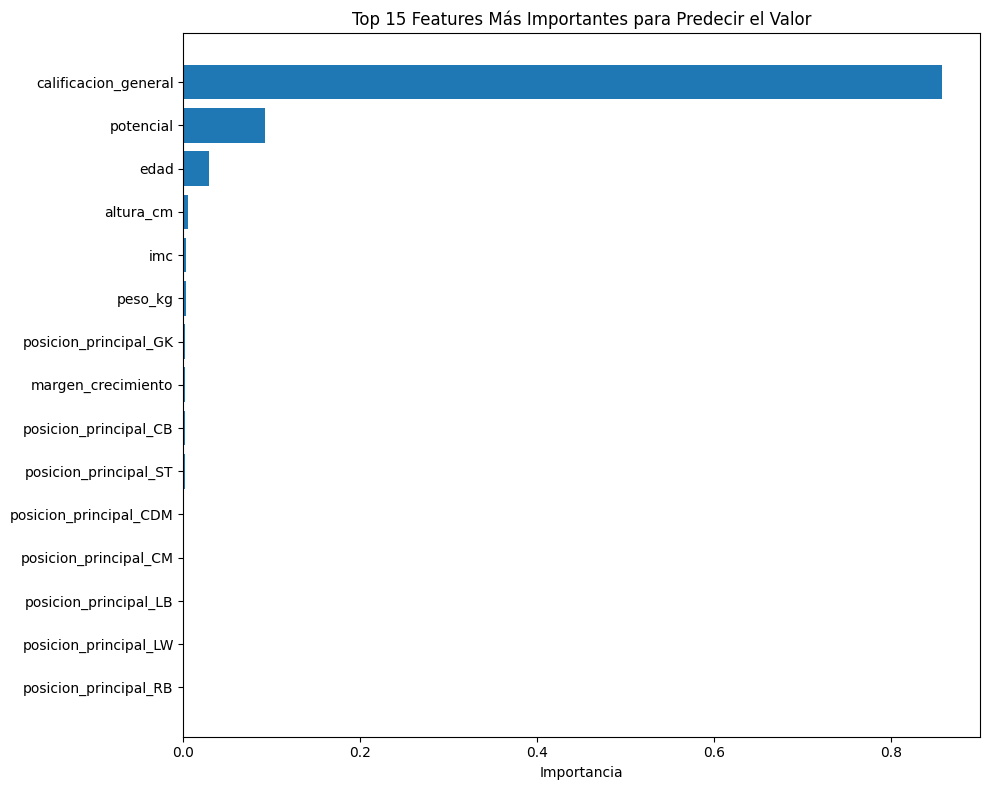

In [31]:
# visualizar con un gráfico simple
import matplotlib.pyplot as plt

# crear gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(df_importancias.head(15)['Feature'], df_importancias.head(15)['Importancia'])
plt.xlabel('Importancia')
plt.title('Top 15 Features Más Importantes para Predecir el Valor')
plt.gca().invert_yaxis()  # invertir para que la más importante esté arriba
plt.tight_layout()
plt.show()

### Interpretación de la Importancia

**¿Qué significa cada valor?**

- Si `calificacion_general` tiene importancia de 0.40 (40%):
  - Esta variable es responsable del 40% de las decisiones del modelo
  - Es LA variable más importante para determinar el valor

- Si `posicion_ST` tiene importancia de 0.15 (15%):
  - Ser delantero centro afecta significativamente el valor
  - Los ST tienden a valer más que otras posiciones

**Conclusión típica:**
- Las variables numéricas (calificación, potencial, edad) suelen ser las más importantes
- Algunas posiciones específicas (ST, CAM) tienen alto impacto
- Variables como altura/peso tienen menos impacto directo

## Identificar Jugadores Infravalorados y Sobrevalorados

Esta es la parte más interesante del proyecto. Vamos a usar el modelo para encontrar oportunidades.

**Jugador Infravalorado:**
- Valor Real < Valor Predicho
- El modelo dice que DEBERÍA valer más de lo que vale
- ¡Oportunidad de compra!

**Jugador Sobrevalorado:**
- Valor Real > Valor Predicho
- El modelo dice que vale MENOS de lo que cuesta
- Cuidado, puede ser caro

In [32]:
# calcular la diferencia entre valor predicho y valor real
# diferencia positiva = infravalorado (vale menos de lo que debería)
# diferencia negativa = sobrevalorado (vale más de lo que debería)
df_comparacion['Diferencia'] = df_comparacion['Valor_Predicho'] - df_comparacion['Valor_Real']

# calcular el porcentaje de diferencia
df_comparacion['Diferencia_Porcentual'] = (df_comparacion['Diferencia'] / df_comparacion['Valor_Real']) * 100

### Top 20 Jugadores Infravalorados

Estos son los jugadores que el modelo identifica como las mejores oportunidades de compra.

In [33]:
# obtener los índices originales para recuperar información del jugador
indices_test = y_test.index
df_comparacion['indice_original'] = indices_test

# filtrar solo jugadores infravalorados (diferencia positiva)
# y con valor real mayor a €500,000 (para filtrar jugadores muy baratos)
infravalorados = df_comparacion[
    (df_comparacion['Diferencia'] > 0) & 
    (df_comparacion['Valor_Real'] > 500000)
].sort_values('Diferencia', ascending=False)

# top 20 infravalorados
top_20_infravalorados = infravalorados.head(20)

print("Top 20 Jugadores INFRAVALORADOS (Mejores Oportunidades):")
print("="*80)
print("Estos jugadores valen MENOS de lo que el modelo predice que deberían valer\n")

# agregar información del jugador
for idx, row in top_20_infravalorados.iterrows():
    jugador_idx = row['indice_original']
    jugador = fifa.loc[jugador_idx]
    
    print(f"Jugador: {jugador['nombre_corto']}")
    print(f"  Posición: {jugador['posicion_principal']} | Edad: {jugador['edad']} | Calificación: {jugador['calificacion_general']}")
    print(f"  Valor REAL: €{row['Valor_Real']:,.0f}")
    print(f"  Valor PREDICHO: €{row['Valor_Predicho']:,.0f}")
    print(f"  OPORTUNIDAD: €{row['Diferencia']:,.0f} ({row['Diferencia_Porcentual']:.1f}%)")
    print("-" * 80)

Top 20 Jugadores INFRAVALORADOS (Mejores Oportunidades):
Estos jugadores valen MENOS de lo que el modelo predice que deberían valer

Jugador: Neymar
  Posición: LW | Edad: 22 | Calificación: 86
  Valor REAL: €31,000,000
  Valor PREDICHO: €53,622,008
  OPORTUNIDAD: €22,622,008 (73.0%)
--------------------------------------------------------------------------------
Jugador: Isco
  Posición: CAM | Edad: 22 | Calificación: 83
  Valor REAL: €15,000,000
  Valor PREDICHO: €32,453,988
  OPORTUNIDAD: €17,453,988 (116.4%)
--------------------------------------------------------------------------------
Jugador: A. Vidal
  Posición: CM | Edad: 27 | Calificación: 85
  Valor REAL: €23,000,000
  Valor PREDICHO: €40,211,835
  OPORTUNIDAD: €17,211,835 (74.8%)
--------------------------------------------------------------------------------
Jugador: Oscar
  Posición: CAM | Edad: 22 | Calificación: 84
  Valor REAL: €21,000,000
  Valor PREDICHO: €36,860,214
  OPORTUNIDAD: €15,860,214 (75.5%)
--------------

### Top 20 Jugadores Sobrevalorados

Estos son los jugadores que el modelo considera que están caros según sus características.

In [34]:
# filtrar jugadores sobrevalorados (diferencia negativa)
sobrevalorados = df_comparacion[
    (df_comparacion['Diferencia'] < 0) & 
    (df_comparacion['Valor_Real'] > 500000)
].sort_values('Diferencia', ascending=True)  # menor diferencia = más sobrevalorado

# top 20 sobrevalorados
top_20_sobrevalorados = sobrevalorados.head(20)

print("Top 20 Jugadores SOBREVALORADOS (Cuidado con estos):")
print("="*80)
print("Estos jugadores valen MÁS de lo que el modelo predice que deberían valer\n")

# agregar información del jugador
for idx, row in top_20_sobrevalorados.iterrows():
    jugador_idx = row['indice_original']
    jugador = fifa.loc[jugador_idx]
    
    print(f"Jugador: {jugador['nombre_corto']}")
    print(f"  Posición: {jugador['posicion_principal']} | Edad: {jugador['edad']} | Calificación: {jugador['calificacion_general']}")
    print(f"  Valor REAL: €{row['Valor_Real']:,.0f}")
    print(f"  Valor PREDICHO: €{row['Valor_Predicho']:,.0f}")
    print(f"  SOBREPRECIO: €{abs(row['Diferencia']):,.0f} ({abs(row['Diferencia_Porcentual']):.1f}%)")
    print("-" * 80)

Top 20 Jugadores SOBREVALORADOS (Cuidado con estos):
Estos jugadores valen MÁS de lo que el modelo predice que deberían valer

Jugador: Cristiano Ronaldo
  Posición: LW | Edad: 32 | Calificación: 94
  Valor REAL: €95,500,000
  Valor PREDICHO: €79,065,839
  SOBREPRECIO: €16,434,161 (17.2%)
--------------------------------------------------------------------------------
Jugador: H. Kane
  Posición: ST | Edad: 24 | Calificación: 89
  Valor REAL: €86,000,000
  Valor PREDICHO: €69,652,514
  SOBREPRECIO: €16,347,486 (19.0%)
--------------------------------------------------------------------------------
Jugador: Z. Ibrahimović
  Posición: ST | Edad: 35 | Calificación: 88
  Valor REAL: €27,000,000
  Valor PREDICHO: €11,676,070
  SOBREPRECIO: €15,323,930 (56.8%)
--------------------------------------------------------------------------------
Jugador: H. Kane
  Posición: ST | Edad: 26 | Calificación: 88
  Valor REAL: €71,000,000
  Valor PREDICHO: €56,012,060
  SOBREPRECIO: €14,987,940 (21.1%)
-

## Guardar el Modelo Entrenado

Ahora que el modelo está entrenado, vamos a guardarlo en un archivo.

¿Para qué?
- No tenemos que entrenar el modelo cada vez que lo usemos
- Podemos cargarlo en el dashboard de Streamlit
- El archivo se llama "pickle" (.pkl) y guarda el modelo completo

In [35]:
# crear carpeta para guardar el modelo si no existe
import os

carpeta_modelos = "../models"
if not os.path.exists(carpeta_modelos):
    os.makedirs(carpeta_modelos)
    print(f"✓ Carpeta '{carpeta_modelos}' creada")
else:
    print(f"✓ Carpeta '{carpeta_modelos}' ya existe")

✓ Carpeta '../models' creada


In [36]:
# guardar el modelo entrenado
ruta_modelo = os.path.join(carpeta_modelos, "modelo_valoracion_fifa.pkl")

with open(ruta_modelo, 'wb') as archivo:
    pickle.dump(modelo, archivo)

print(f"✓ Modelo guardado exitosamente en: {ruta_modelo}")

✓ Modelo guardado exitosamente en: ../models\modelo_valoracion_fifa.pkl


In [37]:
# también guardar el encoder (necesario para el dashboard)
ruta_encoder = os.path.join(carpeta_modelos, "encoder_categoricas.pkl")

with open(ruta_encoder, 'wb') as archivo:
    pickle.dump(encoder, archivo)

print(f"✓ Encoder guardado exitosamente en: {ruta_encoder}")

✓ Encoder guardado exitosamente en: ../models\encoder_categoricas.pkl


In [38]:
# guardar los nombres de las columnas (necesario para el dashboard)
ruta_columnas = os.path.join(carpeta_modelos, "columnas_modelo.pkl")

with open(ruta_columnas, 'wb') as archivo:
    pickle.dump(X.columns.tolist(), archivo)

print(f"✓ Nombres de columnas guardados en: {ruta_columnas}")

✓ Nombres de columnas guardados en: ../models\columnas_modelo.pkl


## Probar Carga del Modelo (Verificación)

Vamos a verificar que el modelo se guardó correctamente cargándolo de nuevo.

In [39]:
# cargar el modelo guardado
with open(ruta_modelo, 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

# cargar el encoder
with open(ruta_encoder, 'rb') as archivo:
    encoder_cargado = pickle.load(archivo)

# cargar las columnas
with open(ruta_columnas, 'rb') as archivo:
    columnas_cargadas = pickle.load(archivo)

print("✓ Modelo cargado exitosamente")
print("✓ Encoder cargado exitosamente")
print("✓ Columnas cargadas exitosamente")
print(f"\nTotal de columnas: {len(columnas_cargadas)}")

✓ Modelo cargado exitosamente
✓ Encoder cargado exitosamente
✓ Columnas cargadas exitosamente

Total de columnas: 24


In [40]:
# hacer una predicción de prueba con el modelo cargado
prediccion_prueba = modelo_cargado.predict(X_test.head(1))

print("Predicción de prueba con modelo cargado:")
print(f"Valor predicho: €{prediccion_prueba[0]:,.2f}")
print(f"Valor real: €{y_test.iloc[0]:,.2f}")
print("\n✓ El modelo funciona correctamente!")

Predicción de prueba con modelo cargado:
Valor predicho: €44,771.73
Valor real: €50,000.00

✓ El modelo funciona correctamente!


## Resumen Final del Modelo

### ¿Qué logramos?

1. ✅ **Entrenamos un modelo** Random Forest con 100 árboles
2. ✅ **Usamos 9 variables** clave para predecir el valor de un jugador
3. ✅ **Evaluamos el rendimiento** con métricas estándar (RMSE, MAE, R²)
4. ✅ **Identificamos jugadores infravalorados** (oportunidades de compra)
5. ✅ **Guardamos el modelo** para usarlo en el dashboard

### ¿Cómo usar este modelo en el Dashboard?

El dashboard de Streamlit tendrá un formulario donde el usuario ingresará:
- Edad del jugador
- Calificación general
- Potencial
- Posición
- Altura, peso, pie preferido
- **Opcionalmente:** Valor actual de mercado

El sistema:
1. Cargará el modelo guardado (modelo_valoracion_fifa.pkl)
2. Procesará los datos ingresados
3. Predecirá el valor justo estimado
4. Si el usuario ingresó el valor actual, lo comparará:
   - Si valor_real < valor_predicho → **INFRAVALORADO** 🟢
   - Si valor_real > valor_predicho → **SOBREVALORADO** 🔴
   - Si son similares → **BIEN VALORADO** 🟡

### Próximos Pasos:

1. Crear el dashboard de Streamlit
2. Integrar el modelo en el dashboard
3. Diseñar la interfaz de usuario
4. Agregar visualizaciones interactivas

## Notas Técnicas

**Archivos generados:**
- `models/modelo_valoracion_fifa.pkl`: Modelo Random Forest entrenado
- `models/encoder_categoricas.pkl`: Encoder para variables categóricas
- `models/columnas_modelo.pkl`: Lista de columnas esperadas por el modelo

**Variables de entrada esperadas:**
- Numéricas: edad, calificacion_general, potencial, altura_cm, peso_kg, imc, margen_crecimiento
- Categóricas: posicion_principal, pie_preferido

**Variable objetivo:**
- valor_euros (valor de mercado en euros)

**Configuración del modelo:**
- Algoritmo: Random Forest Regressor
- Número de árboles: 100
- Max depth: 20
- Datos de entrenamiento: 80% (96,543 jugadores)
- Datos de prueba: 20% (24,136 jugadores)

## Implementación en Código (Dashboard)

Este bloque implementa la lógica para: cargar el modelo, procesar datos de entrada, predecir el valor justo y comparar opcionalmente con un valor real para clasificar al jugador como INFRAVALORADO, SOBREVALORADO o BIEN VALORADO.


In [ ]:
import pickle
from pathlib import Path
from typing import Optional, Dict, Any
import pandas as pd

def cargar_recursos_modelo(
    ruta_modelo: str = "models/modelo_valoracion_fifa.pkl",
    ruta_columnas: str = "models/columnas_modelo.pkl",
):
    """
    Carga el modelo de regresión y la lista de columnas esperadas.
    
    Args:
        ruta_modelo: Ruta al archivo .pkl del modelo entrenado.
        ruta_columnas: Ruta al archivo .pkl con la lista de columnas del modelo.
    
    Returns:
        (modelo, columnas_modelo)
    """
    with open(ruta_modelo, "rb") as f:
        modelo = pickle.load(f)
    with open(ruta_columnas, "rb") as f:
        columnas_modelo = pickle.load(f)
    return modelo, columnas_modelo

def preparar_entrada(entrada: Dict[str, Any], columnas_modelo: list) -> pd.DataFrame:
    """
    Convierte un diccionario de entrada en un DataFrame con las columnas esperadas.
    
    Nota:
        - Si el modelo es un Pipeline que incluye preprocesamiento, bastará con
          suministrar las columnas crudas. Si el modelo espera ya columnas
          codificadas, asegúrate de generar esas columnas previamente.
    
    Args:
        entrada: Diccionario con las características del jugador.
        columnas_modelo: Lista de columnas esperadas por el modelo.
    
    Returns:
        DataFrame con una sola fila alineada a columnas_modelo.
    """
    df = pd.DataFrame([entrada])
    for c in columnas_modelo:
        if c not in df.columns:
            df[c] = 0
    df = df[columnas_modelo]
    return df

def predecir_valor(df_entrada: pd.DataFrame, modelo) -> float:
    """
    Predice el valor de mercado del jugador.
    
    Args:
        df_entrada: DataFrame con una fila y columnas esperadas por el modelo.
        modelo: Modelo de regresión cargado.
    
    Returns:
        Valor predicho en euros.
    """
    pred = modelo.predict(df_entrada)
    return float(pred[0])

def evaluar_valoracion(
    valor_predicho: float,
    valor_real: Optional[float] = None,
    tolerancia_relativa: float = 0.05,
) -> Dict[str, Any]:
    """
    Compara el valor predicho con el valor real y clasifica la valoración.
    
    Reglas:
      - Si valor_real < valor_predicho y la diferencia excede tolerancia → INFRAVALORADO
      - Si valor_real > valor_predicho y la diferencia excede tolerancia → SOBREVALORADO
      - Si la diferencia relativa es menor o igual a tolerancia → BIEN VALORADO
    
    Args:
        valor_predicho: Valor estimado por el modelo.
        valor_real: Valor de mercado actual ingresado por el usuario.
        tolerancia_relativa: Umbral relativo (p.ej. 0.05 = 5%) para considerar “similar”.
    
    Returns:
        Diccionario con clasificacion, diferencia y métricas auxiliares.
    """
    resultado = {
        "valor_predicho": valor_predicho,
        "valor_real": valor_real,
        "clasificacion": None,
        "diferencia": None,
        "diferencia_relativa": None,
    }

    if valor_real is None:
        resultado["clasificacion"] = "SIN_COMPARACION"
        return resultado

    diferencia = valor_predicho - valor_real
    denom = max(abs(valor_predicho), 1e-9)
    dif_rel = abs(diferencia) / denom

    if dif_rel <= tolerancia_relativa:
        clasificacion = "BIEN VALORADO"
    elif diferencia > 0:
        clasificacion = "INFRAVALORADO"
    else:
        clasificacion = "SOBREVALORADO"

    resultado.update(
        {
            "clasificacion": clasificacion,
            "diferencia": diferencia,
            "diferencia_relativa": dif_rel,
        }
    )
    return resultado

# Ejemplo de uso:
# modelo, columnas = cargar_recursos_modelo()
# entrada = {
#     "edad": 23,
#     "calificacion_general": 78,
#     "potencial": 85,
#     "altura_cm": 180,
#     "peso_kg": 75,
#     "imc": 23.1,
#     "margen_crecimiento": 7,
#     "posicion_principal": "CM",
#     "pie_preferido": "Right",
# }
# df_in = preparar_entrada(entrada, columnas)
# vp = predecir_valor(df_in, modelo)
# evaluar_valoracion(vp, valor_real=2_000_000, tolerancia_relativa=0.05)
